In [25]:
import cv2
from imutils import face_utils
import pandas as pd
import numpy as np
import mediapipe as mp

import os
import re
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt


In [26]:
pack_identify = {
    "forehead_top": [10],  # самая верхняя точка головы
    "chin_bottom": [152],  # нижняя точка подбородка
    "head_width": [234, 454],  # крайние боковые точки лица (лево/право)
    "left_eyebrow_top": 70,
    "left_eye_center": 159,
    "right_eyebrow_top": 336,
    "right_eye_center": 386,
}

In [27]:
class Landmark():
    def __init__(self, x : int, y : int):
        self.x = x
        self.y = y

In [28]:
def segment_length(x1, y1, x2, y2):
    return math.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)


def point_to_line_distance(x0, y0, x1, y1, x2, y2):
    numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = segment_length(x1, y1, x2, y2)
    if denominator == 0:
        raise ValueError("Точки x1,y1 и x2,y2 совпадают — нельзя построить прямую.")
    return numerator / denominator, denominator / 2

def safe_relative_deviation(height, base, max_ratio=10.0):
    if base == 0:
        return max_ratio
    ratio = height / base
    return min(ratio, max_ratio)  # защита от взрыва метрики



In [29]:
def get_head_proportion(landmarks):
    # Точки: верх головы (10), подбородок (152), края головы (234, 454)
    x_top = landmarks[10].x
    y_top = landmarks[10].y
    x_chin = landmarks[152].x
    y_chin = landmarks[152].y
    x_left = landmarks[234].x
    y_left = landmarks[234].y
    x_right = landmarks[454].x
    y_right = landmarks[454].y

    height = math.sqrt((x_top - x_chin)**2 + (y_top - y_chin)**2)
    width = math.sqrt((x_left - x_right)**2 + (y_left - y_right)**2)

    return safe_relative_deviation(height, width)


def forehead_is_vertical(landmarks, max_angle=30):
    # Верхняя точка лба
    x0 = landmarks[10].x
    y0 = landmarks[10].y

    # Края лба / висков
    x1 = landmarks[234].x
    y1 = landmarks[234].y
    x2 = landmarks[454].x
    y2 = landmarks[454].y

    distance, _ = point_to_line_distance(x0, y0, x1, y1, x2, y2)

    # длина основания (для нахождения отношения)
    base = segment_length(x1, y1, x2, y2)

    if base == 0:
        return False  # нельзя сказать, линия вырождена

    ratio = distance / (base / 2)

    # Чем ближе к центру — тем вертикальнее
    return ratio < math.tan(math.radians(max_angle))


def get_avg_brow_height(landmarks):
    # Левая бровь и глаз: 70 (верх брови), 159 (центр глаза)
    # Правая бровь и глаз: 336 (верх брови), 386 (центр глаза)

    left_brow_y = landmarks[70].y
    left_eye_y = landmarks[159].y

    right_brow_y = landmarks[336].y
    right_eye_y = landmarks[386].y

    left_height = abs(left_brow_y - left_eye_y)
    right_height = abs(right_brow_y - right_eye_y)

    return (left_height + right_height) / 2



In [30]:
DATASET_ALL_DATA = r"E:\Project VS\Machine-Learning\all_data"

# Загружаем модель
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)



In [31]:
def numeric_key(name):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', name)]

In [32]:
def get_landmarks(image_path):
    image_array = np.fromfile(image_path, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError("Изображение не загружено!")
            
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #height, width = image_rgb.shape[:2]

    # Детектируем лицо
    faces = face_mesh.process(image_rgb)

    if not faces.multi_face_landmarks:
        return

    shape = faces.multi_face_landmarks[0]

    return [Landmark(p.x, p.y) for p in shape.landmark]

In [33]:
head_ratios = []
brow_heights = []
forehead_angles = []
rationality_labels = []
all_devs = []


In [34]:
def build_dataframe_rationality(dataset_dir,
                                t_head_ratios,
                                f_head_ratios,
                                t_brow_heights,
                                f_brow_heights,
                                t_forehead_flags,
                                f_forehead_flags,
                                get_label_func=lambda k: k // 8):

    global all_devs, all_labels
    all_devs = []
    all_labels = []

    k = 0
    for label_dir in sorted(os.listdir(dataset_dir), key=numeric_key):
        label_path = os.path.join(dataset_dir, label_dir)
        if not os.path.isdir(label_path):
            continue

        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(label_path, filename)

                result = get_landmarks(image_path)
                if result is None:
                    continue
                landmarks = result

                # Признаки
                head_ratio = get_head_proportion(landmarks)
                brow_height = get_avg_brow_height(landmarks)
                forehead_is_vert = forehead_is_vertical(landmarks)

                # Метка: 0 – рационал, 1 – иррационал
                label = get_label_func(k) % 2

                # Разделяем по классам
                if label == 0:
                    t_head_ratios.append(head_ratio)
                    t_brow_heights.append(brow_height)
                    t_forehead_flags.append(int(forehead_is_vert))
                else:
                    f_head_ratios.append(head_ratio)
                    f_brow_heights.append(brow_height)
                    f_forehead_flags.append(int(forehead_is_vert))

                # Добавляем в общие списки
                all_devs.append([head_ratio, brow_height, int(forehead_is_vert)])
                all_labels.append(label)

        k += 1


In [35]:
t_head_ratios = []         # Пропорция головы у рационалов
f_head_ratios = []         # Пропорция головы у иррационалов

t_brow_heights = []        # Высота бровей у рационалов
f_brow_heights = []        # Высота бровей у иррационалов

t_forehead_flags = []      # Вертикальность лба у рационалов (True/False)
f_forehead_flags = []      # Вертикальность лба у иррационалов (True/False)



In [36]:
build_dataframe_rationality(
    DATASET_ALL_DATA,
    t_head_ratios=t_head_ratios,
    f_head_ratios=f_head_ratios,
    t_brow_heights=t_brow_heights,
    f_brow_heights=f_brow_heights,
    t_forehead_flags=t_forehead_flags,
    f_forehead_flags=f_forehead_flags
)


In [37]:
print(f"Рационалы (вертикальный лоб) - количество: {len(t_forehead_flags)}")
print(f"Иррационалы (лоб сужается) - количество: {len(f_forehead_flags)}")

print(f"Рационалы (высокие брови) - количество: {len(t_brow_heights)}")
print(f"Иррационалы (низкие брови) - количество: {len(f_brow_heights)}")

print(f"Рационалы (голова вытянута по вертикали) - количество: {len(t_head_ratios)}")
print(f"Иррационалы (голова вытянута по горизонтали) - количество: {len(f_head_ratios)}")


Рационалы (вертикальный лоб) - количество: 37705
Иррационалы (лоб сужается) - количество: 31426
Рационалы (высокие брови) - количество: 37705
Иррационалы (низкие брови) - количество: 31426
Рационалы (голова вытянута по вертикали) - количество: 37705
Иррационалы (голова вытянута по горизонтали) - количество: 31426


In [38]:
#t_avg_dev_mouth = sum(t_procents_mouth)/len(t_procents_mouth)


In [39]:
print(f"Среднее соотношение высоты к ширине головы (Рациональность): {sum(t_head_ratios) / len(t_head_ratios):.3f}")
print(f"Среднее соотношение высоты к ширине головы (Иррациональность): {sum(f_head_ratios) / len(f_head_ratios):.3f}")

Среднее соотношение высоты к ширине головы (Рациональность): 1.102
Среднее соотношение высоты к ширине головы (Иррациональность): 1.093


In [40]:
print(f"Средняя высота бровей (Рациональность): {sum(t_brow_heights) / len(t_brow_heights):.3f}")
print(f"Средняя высота бровей (Иррациональность): {sum(f_brow_heights) / len(f_brow_heights):.3f}")

Средняя высота бровей (Рациональность): 0.052
Средняя высота бровей (Иррациональность): 0.052


In [41]:
print(f"Доля вертикального лба (Рациональность): {sum(t_forehead_flags) / len(t_forehead_flags):.3f}")
print(f"Доля вертикального лба (Иррациональность): {sum(f_forehead_flags) / len(f_forehead_flags):.3f}")


Доля вертикального лба (Рациональность): 0.016
Доля вертикального лба (Иррациональность): 0.017


In [42]:
all_devs = []
all_labels = []

In [46]:
# Объединяем признаки
head_ratios = t_head_ratios + f_head_ratios
brow_heights = t_brow_heights + f_brow_heights
forehead_flags = t_forehead_flags + f_forehead_flags

# Создаем метки (0 — Thinking, 1 — Feeling)
all_labels = [0] * len(t_head_ratios) + [1] * len(f_head_ratios)

# Объединяем всё в all_devs для общего датафрейма
all_devs = list(zip(head_ratios, brow_heights, forehead_flags))


In [47]:
def create_dataframe(sequence, columns, labels):
    df = pd.DataFrame(sequence, columns=columns)
    df['label'] = labels
    df = df.sample(frac=1).reset_index(drop=True)
    return df
df_all = create_dataframe(all_devs, columns=columns_all, labels=all_labels)


In [49]:
# Объявим список признаков
columns_all = ["head_ratio", "brow_height", "forehead_flag"]
head_ratios = t_head_ratios + f_head_ratios
brow_heights = t_brow_heights + f_brow_heights
forehead_flags = t_forehead_flags + f_forehead_flags

# Создание DataFrame'ов (учти, что all_labels уже должен быть сформирован ранее при сборе данных)
df_all = create_dataframe(all_devs, columns=columns_all, labels=all_labels)

# Для каждого отдельного признака (оборачиваем значения в список списков, если это одномерный список)
df_head_ratio = create_dataframe([[x] for x in head_ratios], columns=["head_ratio"], labels=all_labels)
df_brow_height = create_dataframe([[x] for x in brow_heights], columns=["brow_height"], labels=all_labels)
df_forehead_flag = create_dataframe([[x] for x in forehead_flags], columns=["forehead_flag"], labels=all_labels)

# Проверка распределения по меткам
print(df_all["label"].unique())
print(df_all["label"].value_counts())

# Вывод финального DataFrame
df_all


[0 1]
label
0    37705
1    31426
Name: count, dtype: int64


,head_ratio,brow_height,forehead_flag,label
0,0.850517,0.054370,0,0
1,1.061793,0.082047,0,1
2,1.149803,0.039879,0,1
3,1.203680,0.063586,0,0
4,1.253096,0.056567,0,1
...,...,...,...,...
69126,1.377206,0.060216,0,0
69127,0.856478,0.032223,0,1
69128,1.184029,0.048520,0,0
69129,1.186457,0.055451,0,0


In [51]:
df_all['label'].value_counts(normalize=True)


label
0    0.545414
1    0.454586
Name: proportion, dtype: float64

In [52]:
df_head_ratio

,head_ratio,label
0,1.165753,0
1,1.271185,1
2,1.212458,1
3,1.149467,0
4,1.208998,1
...,...,...
69126,1.272211,1
69127,0.911858,0
69128,1.241712,0
69129,1.022386,1


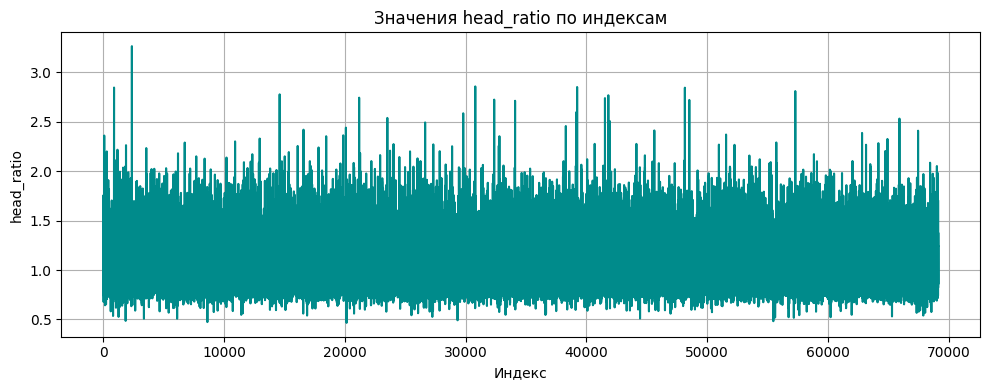

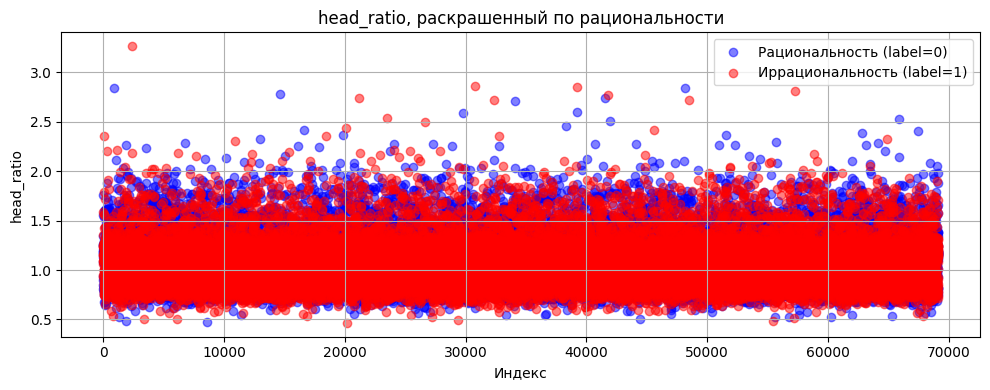

C:\Users\cepib\AppData\Local\Temp\ipykernel_16648\41403275.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_all, x="label", y="brow_height", palette="Set1", jitter=True, alpha=0.5)


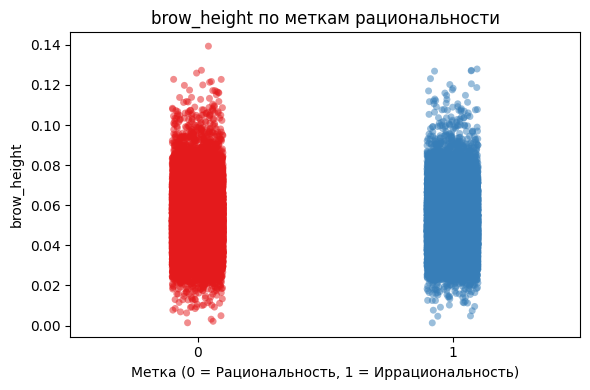

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 График head_ratio по индексам
plt.figure(figsize=(10, 4))
plt.plot(df_all['head_ratio'], color='darkcyan')
plt.title('Значения head_ratio по индексам')
plt.xlabel('Индекс')
plt.ylabel('head_ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🟦🟥 Точки head_ratio с метками Рациональность (0) и Иррациональность (1)
df_0 = df_all[df_all["label"] == 0]["head_ratio"]
df_1 = df_all[df_all["label"] == 1]["head_ratio"]

plt.figure(figsize=(10, 4))
plt.scatter(df_0.index, df_0, color='blue', label='Рациональность (label=0)', alpha=0.5)
plt.scatter(df_1.index, df_1, color='red', label='Иррациональность (label=1)', alpha=0.5)
plt.title("head_ratio, раскрашенный по рациональности")
plt.xlabel("Индекс")
plt.ylabel("head_ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Stripplot для brow_height
plt.figure(figsize=(6, 4))
sns.stripplot(data=df_all, x="label", y="brow_height", palette="Set1", jitter=True, alpha=0.5)
plt.title("brow_height по меткам рациональности")
plt.xlabel("Метка (0 = Рациональность, 1 = Иррациональность)")
plt.ylabel("brow_height")
plt.tight_layout()
plt.show()


In [59]:
print(df_all.columns)


Index(['head_ratio', 'brow_height', 'forehead_flag', 'label'], dtype='object')


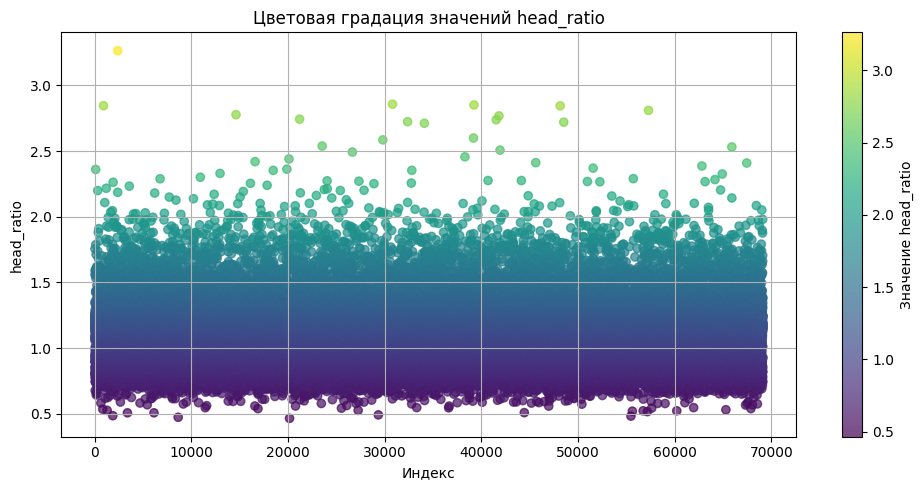

In [60]:
# Отобразим значения head_ratio по индексу с цветовой градацией по самому значению
plt.figure(figsize=(10, 5))
scatter = plt.scatter(df_all.index, df_all['head_ratio'], c=df_all['head_ratio'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Значение head_ratio')  # цветовая шкала
plt.xlabel('Индекс')
plt.ylabel('head_ratio')
plt.title('Цветовая градация значений head_ratio')
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def agg_train_test_split(df: pd.DataFrame):
    return train_test_split(
        df.drop(columns=['label']),  # все колонки кроме 'label'
        df['label'],                 # сами метки
        test_size=0.2,               # 20% на тест
        stratify=df['label'],        # сбалансированная разбивка по классам (исправил с df_all на df)
        random_state=42
    )

def create_model(x_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    return model


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def agg_train_test_split(df: pd.DataFrame):
    return train_test_split(
        df.drop(columns=['label']),   # Все признаки, кроме метки
        df['label'],                  # Целевые метки
        test_size=0.2,                # 20% на тест
        stratify=df['label'],         # Балансировка классов
        random_state=42
    )

def create_model(x_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    return model

# Делим данные
X_train_all, X_test_all, y_train_all, y_test_all = agg_train_test_split(df_all)
X_train_mouth, X_test_mouth, y_train_mouth, y_test_mouth = agg_train_test_split(df_head_ratio)
X_train_brows, X_test_brows, y_train_brows, y_test_brows = agg_train_test_split(df_brow_height)
X_train_jawline, X_test_jawline, y_train_jawline, y_test_jawline = agg_train_test_split(df_forehead_flag)

# Обучаем модели
model_all = create_model(X_train_all, y_train_all)
model_mouth = create_model(X_train_mouth, y_train_mouth)
model_brows = create_model(X_train_brows, y_train_brows)
model_jawline = create_model(X_train_jawline, y_train_jawline)

# Предсказываем
y_pred_all = model_all.predict(X_test_all)
y_pred_mouth = model_mouth.predict(X_test_mouth)
y_pred_brows = model_brows.predict(X_test_brows)
y_pred_jawline = model_jawline.predict(X_test_jawline)

# Выводим точность
print(f"Точность модели на всех признаках: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"Точность модели на признаках рта: {accuracy_score(y_test_mouth, y_pred_mouth):.4f}")
print(f"Точность модели на признаках бровей: {accuracy_score(y_test_brows, y_pred_brows):.4f}")
print(f"Точность модели на признаках линии челюсти: {accuracy_score(y_test_jawline, y_pred_jawline):.4f}")


Точность модели на всех признаках: 0.5454
Точность модели на признаках рта: 0.5454
Точность модели на признаках бровей: 0.5454
Точность модели на признаках линии челюсти: 0.5454


In [63]:
print("Коэффициенты:", model_all.coef_)
print("Смещение:", model_all.intercept_)

Коэффициенты: [[-0.24227347  2.01688997  0.03623825]]
Смещение: [-0.02184821]


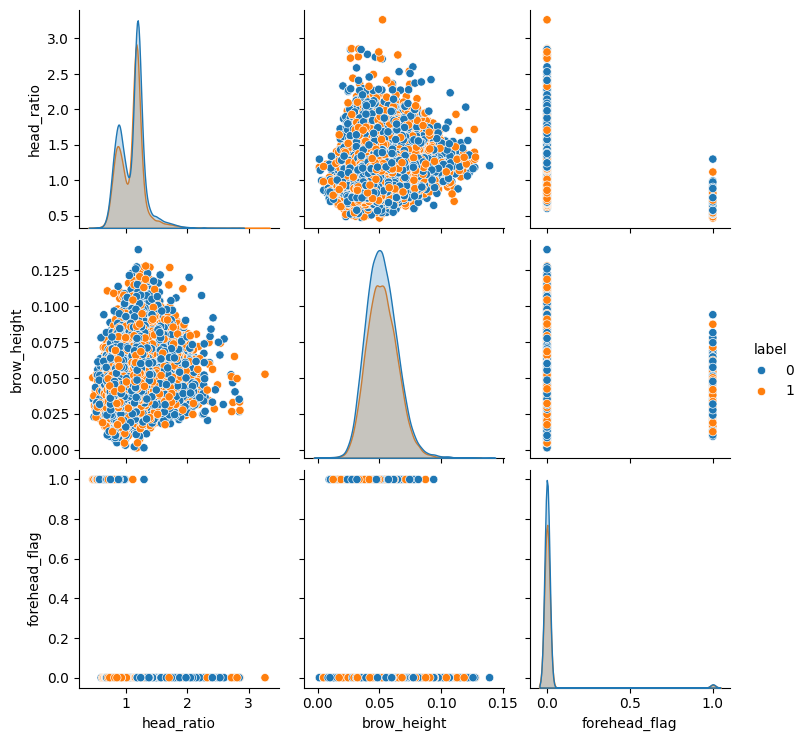

In [64]:
sns.pairplot(df_all, hue='label')

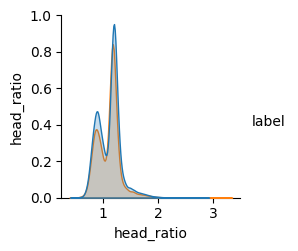

In [65]:
sns.pairplot(df_head_ratio, hue='label')

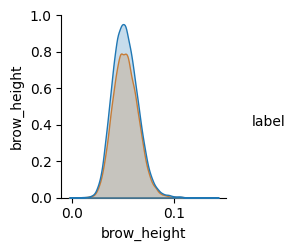

In [66]:
sns.pairplot(df_brow_height, hue='label')

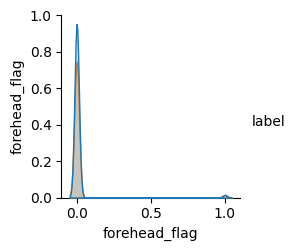

In [67]:
sns.pairplot(df_forehead_flag, hue='label')